In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); 
using ForwardDiff
using Test
using RobotZoo: PlanarQuadrotor
using RobotDynamics
using LinearAlgebra
using StaticArrays
using SparseArrays
using Plots
using Printf

include("quadratic_cost.jl")
include("quadrotor.jl")

 Activating environment at `~/Classes/OptimalControl/hw3_solutions/Project.toml`


run_tests (generic function with 1 method)

# Question 1: Iterative LQR (50 pts)
In this problem you'll implement iterative LQR (ilQR), the Gauss-Newton approximation of differential dynamic programming (DDP). You'll use it to generate trajectories for a planar quadrotor, including a flip. In the last part of the problem, you'll track the trajectory to make it robust to wind.

## The Model
We'll be using the same planar quadrotor model we saw in class. The dynamics are fairly simple:

$$ 
x = \begin{bmatrix} p_x \\ p_z \\ \theta \\ v_x \\ v_z \\ \omega \end{bmatrix}, \quad
\dot{x} = \begin{bmatrix} v_x \\ v_z \\ \omega \\ 
\frac{1}{m} (u_1 + u_2) \sin{\theta} \\
\frac{1}{m} (u_1 + u_2) \cos{\theta} - g \\
\frac{l}{J} (u_2 - u_1) 
\end{bmatrix}
$$
with the following model parameters:
* $m$: mass (kg)
* $J$: moment of inertia
* $l$: distance between motors

In [4]:
# Problem Setup
model = PlanarQuadrotor()
n,m = size(model)          # state and control dimensions
dt = 0.025                 # time step (sec)
tf = 1.5                   # time horizon (sec)
T = Int(tf/dt) + 1         # number of time steps

# Initial & final condition
x0    = SA_F64[-3, 1, 0, 0, 0, 0]                    # initial state
xgoal = SA_F64[+3, 1, 0, 0, 0, 0]                    # goal state
uhover = @SVector fill(0.5*model.mass * model.g, m)  # hover controls

# Cost matrices
Q = Diagonal(SVector{6}([ones(3) ; fill(0.1, 3)]))
R = Diagonal(@SVector fill(1e-2, m))
Qf = Diagonal(@SVector fill(1e2, n));

## Part (a): Implement iLQR
Implement iLQR by completing the provided methods. We provide the following struct that stores the problem definition. Reference the cells below for a brief example of using this struct.

In [5]:
"""
    Problem{n,m,L}

Describes a trajectory optimization problem with `n` states, `m` controls, and 
a model of type `L`. 

# Constructor
    Problem(model::L, obj::Vector{<:QuadraticCost{n,m}}, tf, x0, xf) where {n,m,L}

where `tf` is the final time, and `x0` is the initial state. 
"""
struct Problem{n,m,L}
    model::L
    obj::Vector{QuadraticCost{n,m,Float64}}
    T::Int
    tf::Float64
    x0::MVector{n,Float64}
    times::Vector{Float64}
    function Problem(model::L, obj::Vector{<:QuadraticCost{n,m}}, tf, x0) where {n,m,L}
        @assert length(x0) == n == length(obj[1].q) == state_dim(model)
        @assert length(obj[1].r) == m == control_dim(model)
        T = length(obj)
        times = range(0, tf, length=T)
        new{n,m,L}(model, obj, T, tf, x0, times)
    end
end
Base.size(prob::Problem{n,m}) where {n,m} = (n,m,prob.T)

In [6]:
# Cost function
cost_stage = LQRCost(Q, R, xgoal, uhover)
cost_term = LQRCost(Qf, R, xgoal, uhover)
obj = [cost_stage for k = 1:T-1]
push!(obj, cost_term)

# Build Problem
prob = Problem(model, obj, tf, x0);
n,m,T = size(prob)   # get problem dimensions

# Random trajectory
Xrand = [@SVector randn(n) for k = 1:T]
Urand = [@SVector randn(m) for k = 1:T-1]

# Evaluate the cost
t = prob.times[1]
dt = prob.times[2]-prob.times[1]
cost(prob.obj, Xrand, Urand)

# Evaluate the dynamics
discrete_dynamics(RK4, prob.model, Xrand[1], Urand[1], t, dt)
∇f = zeros(n,n+m)
discrete_jacobian!(RK4, ∇f, prob.model, Xrand[1], Urand[1], t, dt)

### Backward Pass

In [7]:
# TASK: Complete the code below for the backward pass
"""
    backwardpass!(prob, P, p, K, d, X, U)

Evaluate the iLQR backward pass at state and control trajectories `X` and `U`, 
storing the cost-to-go expansion in `P` and `p` and the gains in `K` and `d`.

Should return ΔJ, expected cost reduction.
"""
function backwardpass!(prob::Problem{n,m}, P, p, K, d, X, U; 
        β=1e-6, ddp::Bool=false
    ) where {n,m}
    T = prob.T
    obj = prob.obj
    ΔJ = 0.0
    failed = false
    
    # TODO: Implement the backward pass
   
    return ΔJ
end

backwardpass!

### Forward Pass

In [8]:
# TASK: Complete the method for the forward pass
"""
    forwardpass!(prob, X, U, K, d, ΔJ, J)

Evaluate the iLQR forward pass at state and control trajectories `X` and `U`, using
the gains `K` and `d` to simulate the system forward. The new cost should be less than 
the current cost `J` together with the expected cost decrease `ΔJ`.

Should return the new cost `Jn` and the step length `α`.
"""
function forwardpass!(prob::Problem{n,m}, X, U, K, d, ΔJ, J,
        Xbar = deepcopy(X), Ubar = deepcopy(U);
        max_iters=10,
    ) where {n,m}
    T = prob.T

    # TODO: Implement the forward pass w/ line search
    Jn = J
    α = 0.0
    
    return Jn, α
end


forwardpass!

### iLQR Algorithm

In [9]:
# TASK: Complete the code below to implement iLQR
"""
    solve_ilqr(prob, X, U; kwargs...)

Solve the trajectory optimization problem specified by `prob` using iterative LQR.
Returns the optimized state and control trajectories, as well as the local control gains,
`K` and `d`.

Should return the optimized state and control trajectories `X` and `U`, and the 
list of feedback gains `K` and cost-to-go hessians `P`.
"""
function solve_ilqr(prob::Problem{n,m}, X0, U0; 
        iters=100,     # max iterations
        ls_iters=10,   # max line search iterations
        reg_min=1e-6,  # minimum regularizatio for the backwardpass
        verbose=0,     # print verbosity
        eps=1e-5,      # termination tolerance
        eps_ddp=eps    # tolerance to switch to ddp
    ) where {n,m}
    t_start = time_ns()
    Nx,Nu,Nt = size(prob)

    # Initialization
    T = prob.T
    p = [zeros(n) for k = 1:T]      # ctg gradient
    P = [zeros(n,n) for k = 1:T]    # ctg hessian
    d = [zeros(m) for k = 1:T-1]    # feedforward gains
    K = [zeros(m,n) for k = 1:T-1]  # feedback gains
    Xbar = [@SVector zeros(n) for k = 1:T]    # line search trajectory
    Ubar = [@SVector zeros(m) for k = 1:T-1]  # line search trajectory
    ΔJ = 0.0

    # Don't modify the trajectories that are passed in
    X = deepcopy(X0)
    U = deepcopy(U0)

    # Initial cost
    J = cost(prob.obj, X, U)
    
    # Initialize parameters
    Jn = Inf
    iter = 0
    tol = 1.0
    β = reg_min
    while tol > eps 
        iter += 1
        
        # TODO: Implement iLQR

        # Output
        if verbose > 0
            @printf("Iter: %3d, Cost: % 6.2f → % 6.2f (% 7.2e), res: % .2e, β= %.2e, α = %.3f\n",
                iter, J, Jn, J-Jn, tol, β, α
            )
        end
        J = Jn

        if iter >= iters
            @warn "Reached max iterations"
            break
        end

    end
    println("Total Time: ", (time_ns() - t_start)*1e-6, " ms")
    return X,U,K,P
end


solve_ilqr

## Part (b): Simple trajectory
Use your iLQR solver to move the quadrotor from the initial state to the goal state. Initialize it with a simple hover trajectory (i.e. holding it's initial position).

In [36]:
# TASK: Solve for the optimized trajectories using iLQR
#       Store the results in Xline, Uline

# Initial guess
X0 = [copy(x0) for k = 1:T]
U0 = [copy(uhover) for k = 1:T-1]

# TODO: Solve for optimal trajectories
Xline = deepcopy(X0)
Uline = deepcopy(U0);

In [11]:
vis = Visualizer()
set_mesh!(vis, model)
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8700
└ @ MeshCat /home/brian/.julia/packages/MeshCat/GlCMx/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()))))))), Set{Any}(), ip"127.0.0.1", 8700))

In [37]:
visualize!(vis, model, tf, Xline)

## Part (c): Generate Cost function for Flip
Generate a reference trajectory for the cost function. Since we're designing it by hand we'll do something simple. Complete the function below to generate a trajectory that does the following:
* 0.0-0.5 sec: Moves linearly from -2 to 0 in x
* 0.5-1.0 sec: Moves linearly from 1 to 3 and back to 1 in y. Rotates 360 degrees. No movement in x.
* 1.0-1.5 sec: Moves linearly from 0 to 3 in x.

The velocities should be consistent with the positions.

The trajectory should look like the following:
![flip_traj](flip_reference.png)

In [15]:
# TASK: Implement the following method
"""
    flip_reference

Generate a reference trajectory for the quadrotor that encourages it to do a flip.
The trajectory should have a length of 61.
"""
function flip_reference()
    # TODO: Design the reference trajectory according to the specs above
    x1ref = zeros(61)
    x2ref = zeros(61)
    θref = zeros(61)
    v1ref = zeros(61)
    v2ref = zeros(61)
    ωref = zeros(61)
    
    xref = [x1ref'; x2ref'; θref'; v1ref'; v2ref'; ωref']
    return [SVector{6}(x) for x in eachcol(xref)]
end

flip_reference

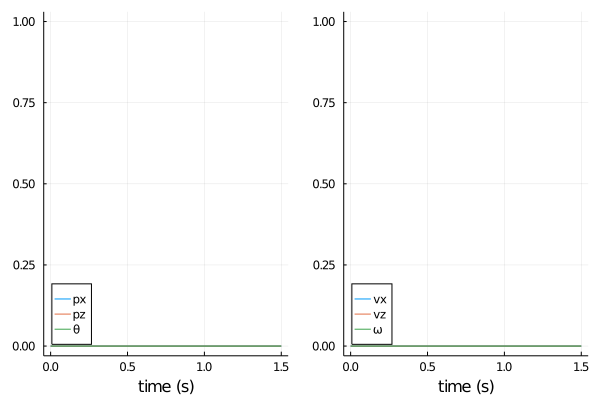

In [16]:
# Plot the reference trajectory
Xref = flip_reference()
p = plot(layout=(1,2))
prob.times
plot!(p[1], prob.times, Xref, inds=1:3, xlabel="time (s)", labels = ["px" "pz" "θ"], legend=:bottomleft)
plot!(p[2], prob.times, Xref, inds=4:6, xlabel="time (s)", labels = ["vx" "vz" "ω"], legend=:bottomleft)

Generate a new time-varying objective that tracks the reference trajectory. Check out the types in `quadratic_cost.jl` for some convenient constructors.

In [18]:
# TASK: design the time-varying tracking objective
#       save it as the variable obj_flip::Vector{<:QuadraticCost}
obj_flip = copy(obj);

## Part (d): Optimize the Flip Trajectory
Using the reference trajectory and the objective you specified in the previous part, construct a new problem and solve it with your iLQR solver. Use a simple hover trajectory as the initial guess.

In [50]:
# TASK: Solve for Xflip, Uflip, the optimized trajectories to flip the quadrotor
#       Also save the feedback matrices and ctg Hessians as K and P, respectively

Xflip, Uflip, K, P = deepcopy(X0), deepcopy(U0), [zeros(m,n) for k = 1:T-1], [zeros(n,n) for k = 1:T];

In [51]:
render(vis)

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String,MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()))))))), Set(Any[WebSocket(server, CONNECTED), WebSocket(server, CONNECTED), WebSocket(server, CONNECTED)]), ip"127.0.0.1", 8700))

In [52]:
visualize!(vis, model, tf, Xflip)

## Part (e): Compare to TVLQR
iLQR generates a local linear feedback controller. As we saw in class, the backwardpass in iLQR is basically TVLQR with some extra terms. However, as our trajectory converges to a stationary point, these extra linear terms should go to zero. When iLQR exits, theses local feedback gains should closely match the result out of TVLQR. Using your code from the previous homework, generate a TVLQR solution for the optimized flip trajectory, using the same cost matrices used in your iLQR solver. They should match to reasonable numerical precision.

In [53]:
# TODO: Generate Klqr, Plqr, the feedback and cost-to-go matrices from TVLQR
#       to track the optimized flip trajectory

Klqr = [zeros(m,n) for k = 1:T-1]
Plqr = [zeros(n,n) for k = 1:T];

In [54]:
@test maximum(norm.(K - Klqr,Inf)) < 1e-3
@test maximum(norm.(P - Plqr,Inf)) < 1e-3

Test Passed

## Part (f): Closed-Loop Tracking
Now that we've seen that the controller generated by iLQR is nearly identical to the TVLQR solution with the same cost matrices, let's use the iLQR gains to track our trajectory, and see how robust it is to wind gusts.

In [55]:
# TODO: Generate two controllers to use in the simulations below:
#       1. LQR controller: Should use the time-varying gains from your iLQR solver
#       2. Open loop: Should use the control trajectory from your iLQR. No feedback.
#       Both controllers should be types that implement the `get_control(ctrl, x, t)` method
#       TIP: Feel free to use structs from HW2

"""
    LQRController

A TVLQR controller that tracks the trajectory specified by `Xref` and `Uref`
using the linear feedback gains `K`.
"""
struct LQRController
    # TODO: add the fields you need
end

function get_control(ctrl::LQRController, x, t)
    # TODO: implement the controller
    u = zeros(2)
    return u
end

"""
    OpenLoopController

A controller that just applies an open-loop control policy of sending a 
set trajectory of control values.
"""
struct OpenLoopController
    # TODO: add the fields you need
end

function get_control(ctrl::OpenLoopController, x, t)
    # TODO: implement the controller
    u = zeros(2)
    return u
end

# TODO: Generate controllers
lqr = LQRController()
openloop = OpenLoopController()

@test get_control(lqr, Xflip[1], 0.0) - Uflip[1] ≈ zeros(2)

Test Failed at In[55]:43
  Expression: get_control(lqr, Xflip[1], 0.0) - Uflip[1] ≈ zeros(2)
   Evaluated: [-4.905, -4.905] ≈ [0.0, 0.0]


LoadError: [91mThere was an error during testing[39m

In [30]:
render(vis)

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String,MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()))))))), Set(Any[WebSocket(server, CONNECTED), WebSocket(server, CONNECTED)]), ip"127.0.0.1", 8700))

In [46]:
# Simulate with LQR
Xlqr, Ulqr, tlqr = simulate(prob.model, Xflip[1], lqr)
visualize!(vis, model, tlqr[end], Xlqr)

Controller ran at 983062.319704759 Hz


In [47]:
# Simulate with open-loop controls
Xopen, Uopen, topen = simulate(model, Xflip[1], openloop)
visualize!(vis, model, topen[end], Xopen)

Controller ran at 1.496822319829215e6 Hz


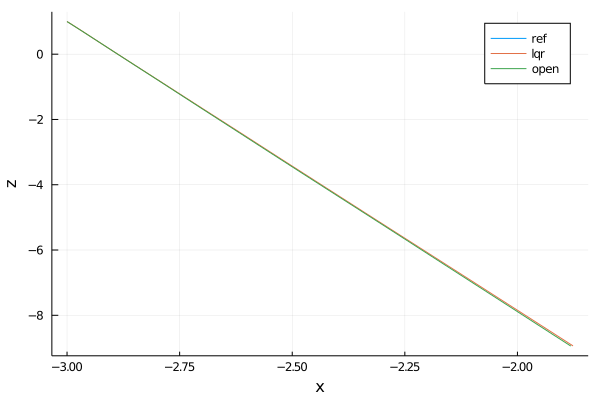

In [48]:
# Plot the trajectories
traj2(Xflip, label="ref")
traj2!(Xlqr, label="lqr")
traj2!(Xopen, label="open", ylabel="z")

## Tests

In [56]:
run_tests();

Total Time: 0.122253 ms
Line Problem solution: Test Failed at /home/brian/Classes/OptimalControl/hw3_solutions/test/q1.jl:27
  Expression: cost(obj, X0, U0) > J
   Evaluated: 2880.24059025 > 2880.24059025
Stacktrace:
 [1] top-level scope at /home/brian/Classes/OptimalControl/hw3_solutions/test/q1.jl:27
 [2] top-level scope at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/Test/src/Test.jl:1115
 [3] top-level scope at /home/brian/Classes/OptimalControl/hw3_solutions/test/q1.jl:23
 [4] top-level scope at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/Test/src/Test.jl:1115
 [5] top-level scope at /home/brian/Classes/OptimalControl/hw3_solutions/test/q1.jl:5
Line Problem solution: Test Failed at /home/brian/Classes/OptimalControl/hw3_solutions/test/q1.jl:28
  Expression: J < 500
   Evaluated: 2880.24059025 < 500
Stacktrace:
 [1] top-level scope at /home/brian/Classes/OptimalControl/hw3_solutions/test/q1.jl:28
 [2] top-level scope at /buildworke

┌ Warning: Reached max iterations
└ @ Main In[9]:59



 [1] top-level scope at /home/brian/Classes/OptimalControl/hw3_solutions/test/q1.jl:50
 [2] top-level scope at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/Test/src/Test.jl:1115
 [3] top-level scope at /home/brian/Classes/OptimalControl/hw3_solutions/test/q1.jl:44
 [4] top-level scope at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/Test/src/Test.jl:1115
 [5] top-level scope at /home/brian/Classes/OptimalControl/hw3_solutions/test/q1.jl:5
Flip reference: Test Failed at /home/brian/Classes/OptimalControl/hw3_solutions/test/q1.jl:53
  Expression: ≈(Xref_[3, end], -2pi, atol = 1.0e-6)
   Evaluated: 0.0 ≈ -6.283185307179586 (atol=1.0e-6)
Stacktrace:
 [1] top-level scope at /home/brian/Classes/OptimalControl/hw3_solutions/test/q1.jl:53
 [2] top-level scope at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/Test/src/Test.jl:1115
 [3] top-level scope at /home/brian/Classes/OptimalControl/hw3_solutions/test/q1.jl:44
 [4] t

┌ Warning: Reached max iterations
└ @ Main In[9]:59


Tracking: Test Failed at /home/brian/Classes/OptimalControl/hw3_solutions/test/q1.jl:87
  Expression: norm((Xlqr[end] - xgoal2)[1:3]) < 0.2
   Evaluated: 9.13279654858038 < 0.2
Stacktrace:
 [1] top-level scope at /home/brian/Classes/OptimalControl/hw3_solutions/test/q1.jl:87
 [2] top-level scope at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/Test/src/Test.jl:1115
 [3] top-level scope at /home/brian/Classes/OptimalControl/hw3_solutions/test/q1.jl:84
 [4] top-level scope at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/Test/src/Test.jl:1115
 [5] top-level scope at /home/brian/Classes/OptimalControl/hw3_solutions/test/q1.jl:5
Test Summary:           | Pass  Fail  Total
Q1                      |   82    70    152
  Line Problem          |    5            5
  Line Problem solution |    7     3     10
  Flip reference        |    4     5      9
  Flip objective        |   61    60    121
  Flip solution         |    4     1      5
  Tracking 

LoadError: LoadError: [91mSome tests did not pass: 82 passed, 70 failed, 0 errored, 0 broken.[39m
in expression starting at /home/brian/Classes/OptimalControl/hw3_solutions/test/q1.jl:4

## EXTRA CREDIT
If we plot the controls for the flip trajectory (shown below), you'll notice that the controls go negative, which is unrealistic for most quadrotors. Find a way to ensure that the inputs don't go negative while executing the flip trajectory.

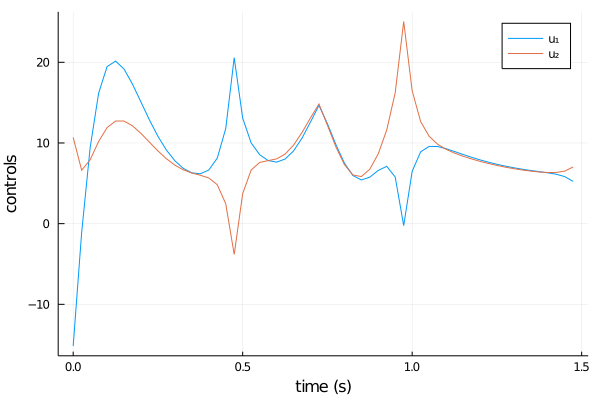

In [34]:
plot(prob.times[1:end-1], Uflip, xlabel="time (s)", ylabel="controls", label=["u₁" "u₂"])